# Scaling down with DETR.




## 1) Student Credentials
This blog post is made by students of the TU Delft as part of the seminar Computer Vision. The students are:

*   Jeroen Hofland, 4678141, j.l.hofland@student.tudelft.nl
*   Jochem van Lith, 4917634, j.a.e.vanlith@student.tudelft.nl

## 2) Introduction
Object detection is a crucial task in computer vision that plays an important role in various applications, ranging from automating tasks and enhancing image understanding to improving security surveillance systems. In recent years, significant advancements have been made in this field, with the emergence of new methods that use Transformers [1].

One such an approach is the DEtection TRansformer (DETR), which revolutionized object detection with its end-to-end architecture and self-attention mechanisms based on transformers [2]. This allows the method to tackle object detection in a more comprehensive way by both looking at local and global spatial features.

By doing so the method surpassed traditional approaches like YOLO [3] and Faster R-CNN [4] in many aspects. However, one area where DETR struggles is detecting small objects within images. Recent advancements aimed at addressing this limitation are DEtection Split TRansformer (DESTR) and SOF-DETR [5,6]. While these methods yield a slight increase of accuracy on small objects, it is still around half of that of medium and large objects. Therefore, it remains crucial to understand when and why DETR encounters difficulties detecting small objects.

The size of an object is determined by its number of pixels. In other words, small objects are inherently represented by less pixels making detection more challenging. Now if this is what causes DETR's problems with small objects, then it will also be highly sensitive to lower resolution images. We aim to investigate this by asking the following experimental question:

**How does the Average Precision per object size change for lower resolution
images?**

In this blog we will explain DETR, introduce the performed experiments, present the results, and end with a conclusion.

## 3) DETR Explained
Many object detection methods predict bounding boxes and corresponding category labels indirectly [2]. Solving subproblems and combining solutions often greatly impacts the performance. DETR is a method which avoids splitting the object detection problem, instead it takes an end-to-end approach. This approach has been tried before [7,8,9,10], but they could not outperform competing baseline methods or included prior knowledge. On the other hand, DETR yields state-of-the art performance and does not require any form of prior knowledge.

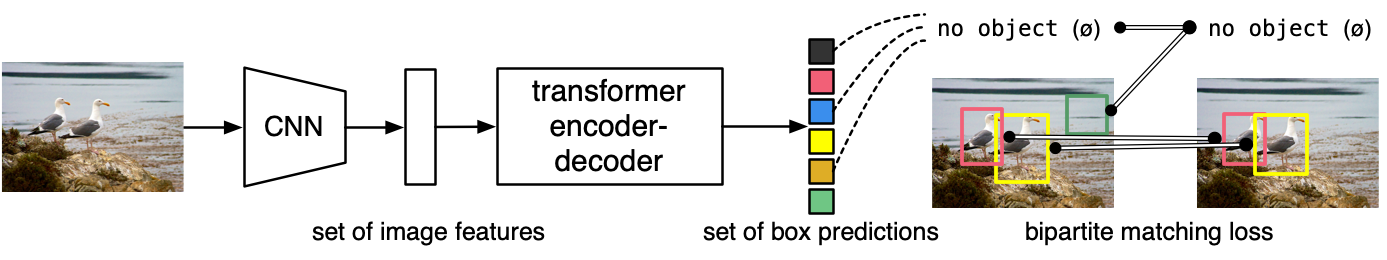
**Figure 1.** Architecture of DETR

DETR combines a CNN and encoder-decoder architecture which uses transformers to directly predict the final set of detections (displayed in Figure 1). Bipartite matching is used during training such that a ground truth box gets assigned a single prediction. Remaining predictions after matching are assigned to the ‘no object’ class.

The transformers used in the encoder-decoder architecture were originally designed for natural language processing tasks. These transformers are adapted to the field of computer vision which enables DETR to perform comprehensive object detection by using both global and local contextual information within an image. The self-attention mechanism used by DETR allows it to efficiently process information across different spatial locations and scales, leading to state-of-the art performance in detecting objects.


## 4) Experiments
In this part we will perform the experiments. We will use the COCO 2017 Validation dataset, similar to the original DETR paper. For this experiment we will use the baseline of DETR with a resnet-50 backbone, as this model can smoothly be loaded into Google Collab and yields only slightly lower performance than the more sophisticated versions.

In the experiment we will try to answer the experimental question by first calculating the average precision for a range of resolutions and images. This way we can see the behaviour of DETR when we scale down the image's pixels and thereby its objects. By doing so, we can get an idea of the influence the resolution has on the performance of DETR. When we focus on the smaller resolutions of the image this might gives us a better insight in the performace of smaller objects.

We continue by performing a similar experiment whilst now also taking into account the object size in each image. We do this by looping over the images and filtering over the predicted bounding boxes in the image. Each predicted bounding box is added to a bin based on the size of the box. By plotting a line for each resolution with the average precision over the bin size (maximum bounding box size), we can get insights into how these properties correlate.

We expect that when we scale down the image, the average precision will also decrease. Because of DETR's problems with small objects, we expect it to be especially sensitive to the lowest resolutions resulting in a drastic reduce of the average precision.

When also taking into account the bounding box sizes, we expect that an DETR will perform similarly with a resolution of 100 pixels and an object of 50 pixels as a resolution of 200 pixels and an object of 25 pixels. This is our expectation, because doubling the object size while halving the resolution will still give the same amount of pixels for the object. For humans this object will thus look equal. This principle can be seen in the figure below (notice that the 100 and 200px are the absolute pixels of the object not the pixels in the image).




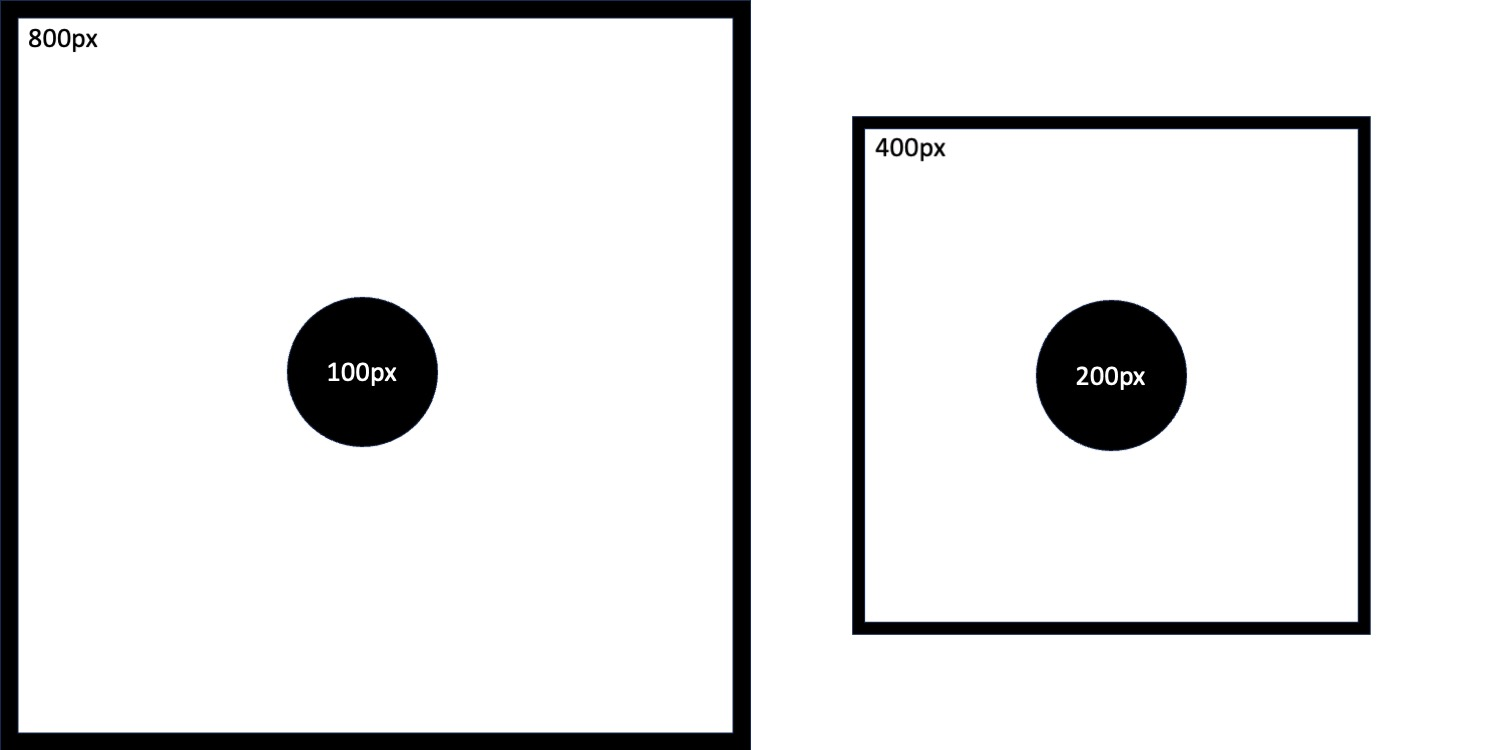
**Figure 2.** Halving resolution while doubling object size. Note that the circle on the right is annotated with 200 pixels for the sake of visualization. In the actual downscaled image, the amount of pixels will again become 100.

### 4.1) Data and model preparation
This section contains code for importing the required libraries, loading the dataset, model, classes, and colors.

In [ ]:
#@title Importing required libraries
# Data
import numpy as np
import json
from PIL import Image

# Helper
import math
import os
import requests
from google.colab import drive

# Torch
import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

# COCO
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# Visualization
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'


In [ ]:
#@title Load dataset and model
# Download dataset annotations
!wget -c http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -o "annotations_trainval2017.zip"

# Load annotations into COCO object
coco_annotation_file_path = "annotations/instances_val2017.json"
coco_annotation = COCO(annotation_file=coco_annotation_file_path)

# Retrieve model and load it
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model.eval();

In [ ]:
#@title COCO classes and colors
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# Colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

### 4.2) Helper functions
In this secion we define some helper functions for the experiment.

In [ ]:
#@title Bounding box rescaling
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [ ]:
#@title Plotting bounding boxes
def plot_results(pil_img, prob, boxes, path, f_name):
    # Init figure
    fig = plt.figure(figsize=(16, 10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        # Construct image
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')

    # create directory
    if not os.path.exists(path):
      os.mkdir(path)

    plt.savefig(f"{path}/{f_name}.jpg", bbox_inches="tight", pad_inches=0)
    plt.close(fig)

def plot_gt(img_id, img, path):
    # Retrieve annotations
    ann_ids = coco_annotation.getAnnIds(imgIds=[img_id], iscrowd=None)
    anns = coco_annotation.loadAnns(ann_ids)

    # Init figure
    fig = plt.figure(figsize=(16, 10))
    plt.imshow(img)
    ax = plt.gca()
    colors = COLORS * 100
    for ann, c in zip(anns, colors):
        # Construct image
        xmin, ymin, w, h = ann['bbox']
        ax.add_patch(plt.Rectangle((xmin, ymin), w, h,
                                   fill=False, color=c, linewidth=3))
        category_id = ann['category_id']
        category_info = coco_annotation.loadCats(category_id)[0]
        label = category_info['name']
        text = f'{label}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')

    # create directory
    if not os.path.exists(path):
      os.mkdir(path)

    plt.savefig(f"{path}/ground_truth.jpg", bbox_inches="tight", pad_inches=0)
    plt.close(fig)

In [ ]:
#@title Resizing images
def pil_to_resized_tensor_with_normalization(image, target_size):
  # transform and normalize image
  transform = T.Compose([
    T.Resize(target_size),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

  # return transformed and unsqueezed image
  return transform(im)

def pil_to_resized_tensor(image, target_size):
  # transform image
  transform = T.Compose([
    T.Resize(target_size),
    T.ToTensor()
  ])

  # return transformed and unsqueezed image
  return transform(im)

In [ ]:
#@title Retrieving and formatting bounding boxes
def return_values(image, confidence):
  # propagate through the model
  output = model(image)

  # keep only predictions with 0.7+ confidence
  probas = output['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > confidence

  return output, probas, keep

def process_output(img_id, prob, boxes, pred_list):
    # Loop over predicted boxes and confidence scores
    for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
        # Get required vals
        cl = p.argmax()
        category_id = cl.item()
        confidence = p[cl].item()
        w = xmax - xmin
        h = ymax - ymin

        # Add to dictionary
        ann_dict = {'image_id': img_id, 'bbox': [xmin, ymin, w, h], 'score': confidence, 'category_id': category_id}
        pred_list.append(ann_dict)

### 4.3) Compute predictions
This section runs DETR on the COCO 2017 validation set for different inout image resolutions. The qualitative results are stored in the local directory. The annotations are stored in the two dictionaries 'ground_truth' and 'predictions'. In the next section we will use these to compute the average precision. Due to possible computing limitations one can choose to run both experiments or run them seperately. For the same reasons it is possible to change the number of images and the list of different resolutions. These can all be edited below.

In [ ]:
#@title Customizable parameters
# Choose which experiments to run
QUANTITATIVE = True
QUALITATIVE = False

# Numbers of IMGs
NUM_IMGS = 5000
img_ids = coco_annotation.getImgIds()[0:NUM_IMGS]

# Resolutions to include in experiments
resolutions = [100, 200, 300, 400, 500, 600, 700, 800]

In [ ]:
#@title Compute predictions

# Init dictionaries to store results
predictions = {}
for size in resolutions:
  predictions[str(size)] = []

for i, img_id in enumerate(img_ids):
  # Print progress
  print(str(i+1) + '/' + str(len(img_ids)))

  # Load image
  img_info = coco_annotation.loadImgs([img_id])[0]
  img_url = img_info["coco_url"]
  im = Image.open(requests.get(img_url, stream=True).raw)

  # Get the size of the image
  width, height = im.size
  total_pixels = width * height

  if QUALITATIVE:
    # Plot ground truth annotations
    plot_gt(img_id, im, path)

    # Create root directory for image results
    path = "./" + str(img_id)
    if not os.path.exists(path):
        os.mkdir(path)

  # Predict for each resolution
  for size in resolutions:
    # Normalize the resized tensor
    normalized_tensor = pil_to_resized_tensor_with_normalization(im, size).unsqueeze(0)
    tensor = pil_to_resized_tensor(im, size)
    pil_image = T.ToPILImage()(tensor)

    # propagate through the model
    output, probas, keep = return_values(normalized_tensor, 0.8)

    # Get the size of the image
    width_new, width_new = pil_image.size
    total_pixels_new = width_new * width_new

    # Quantitative: store results in dictionary
    if QUANTITATIVE:
      # convert boxes from [0; 1] to image scales
      bboxes = rescale_bboxes(output['pred_boxes'][0, :], im.size)
      process_output(img_id, probas, bboxes, predictions[str(size)])

    # Qualitative: store annotated images
    if QUALITATIVE:
      # convert boxes from [0; 1] to image scales
      bboxes_orig = rescale_bboxes(output['pred_boxes'][0, keep], im.size)
      path_orig = path + "/" + str(size)
      plot_results(im, probas[keep], bboxes_orig, path_orig, "orig_img")

      # convert boxes from [0; 1] to image scales
      bboxes_downscaled = rescale_bboxes(output['pred_boxes'][0, keep], pil_image.size)
      path_downscaled = path + "/" + str(size)
      plot_results(pil_image, probas[keep], bboxes_downscaled, path_downscaled, "downscaled_img")

In [ ]:
#@title (Optional) save to drive
# Mount to drive
drive.mount("/content/drive", force_remount=True)

# Path to results
path = '/content/drive/MyDrive/SCV/results'

# Create folder if it does not exists
if not os.path.exists(path):
   os.makedirs(path)

# Open file and save predictions
with open("/content/drive/MyDrive/SCV/results/predictions_" + str(resolutions) + ".json", "w") as outfile:
    json.dump(predictions, outfile)

### 4.4) Calculate average precision (AP)
We will now calculate the average precision for each resolution. We save this in a dictionary which can be used in the results section and evaluation. In the code we use COCOeval to compare the predicted boxes to the ground truths of COCO itself.

In [ ]:
#@title Calculate AP vs Resolution
# Init dict to store results
results_resolutions = {}

# Set annotations type
annotations_type = 'bbox'

# Initialize COCO ground truth api
coco_annotation_file_path = '/content/annotations/instances_val2017.json'
coco_ground_truth = COCO(coco_annotation_file_path)

# Loop over resolutions
for size in resolutions:
    #initialize COCO detections api
    predictions_file = predictions[str(size)]
    coco_predictions = coco_ground_truth.loadRes(predictions_file)

    # Run evaluation
    cocoEval = COCOeval(coco_ground_truth, coco_predictions, annotations_type)
    cocoEval.params.imgIds = img_ids
    cocoEval.evaluate()
    cocoEval.accumulate()

    # Print and save results
    print('Results for resolution:' + str(size))
    cocoEval.summarize()
    results_resolutions[str(size)] = cocoEval.stats

Now that we have AP vs Resolution we can further break down the problem by calculating the AP for different bins of object resolutions. Thus not only looking at image resolution but also object resolution. Each bin allows for images twice the size of the previous bin. We can visualize this as:

```
bins = [0-50, 51-100, 101-200, 201-400, 401-800, ...]
```

An example of such split can be found in the image below (5 bounding boxes). As you can see the remotes are put in the bin of max 50 pixels, the cats in the max 200 pixels bin and the couch in the max 400 pixels. This allows us to run each of these prediction sets against the coco dataset and calculate their average precision seperately. Notice that an image can have multiple bounding boxes that can be in multiple bins.

In [ ]:
#@title Calculate AP vs Object Size per Resolution

# Init dict to store results
results = {}

#initialize COCO ground truth api
annFile = '/content/annotations/instances_val2017.json'
cocoGt=COCO(annFile)

# Define the bin size
bin_size = 25

# Create list of bin size where each bin is double the size of the previous bin
bin_sizes = []
for i in range(20):
    bin_sizes.append(bin_size * 2 ** i)

# Loop over each size and bin
for resolution in resolutions:
  # Dictionary to store the filtered annotations
  filtered_annotations = {}
  results[resolution] = {}

  # Filter annotations for each bin
  for annotation in predictions[str(resolution)]:
      # Calculate the bin index for the current annotation
      bbox_area = annotation['bbox'][2] * annotation['bbox'][3]

      # Find the bin index for the current bbox area
      bin_index = 0
      for i, size in enumerate(bin_sizes):
          if bbox_area <= size:
              bin_index = i
              break

      # Create the bin if it doesn't exist in the dictionary
      if bin_sizes[bin_index] not in filtered_annotations:
          filtered_annotations[bin_sizes[bin_index]] = []

      # Add the image information and annotation to the filtered annotations
      filtered_annotations[bin_sizes[bin_index]].append(annotation)

  filtered_annotations = dict(sorted(filtered_annotations.items()))

  for bin, annotations in filtered_annotations.items():
    #initialize COCO detections api
    cocoDt=cocoGt.loadRes(annotations)

    # Setup coco evaluation
    annType = 'bbox'
    cocoEval = COCOeval(cocoGt,cocoDt,annType)

    # Get image ids
    cocoEval.params.imgIds = img_ids

    # Evaluate, accumulate and summarize
    cocoEval.evaluate()
    cocoEval.accumulate()
    print('Results for resolution:' + str(resolution) + ' and bin ' + str(bin))
    cocoEval.summarize()

    # Save results
    results[resolution][bin] = cocoEval.stats



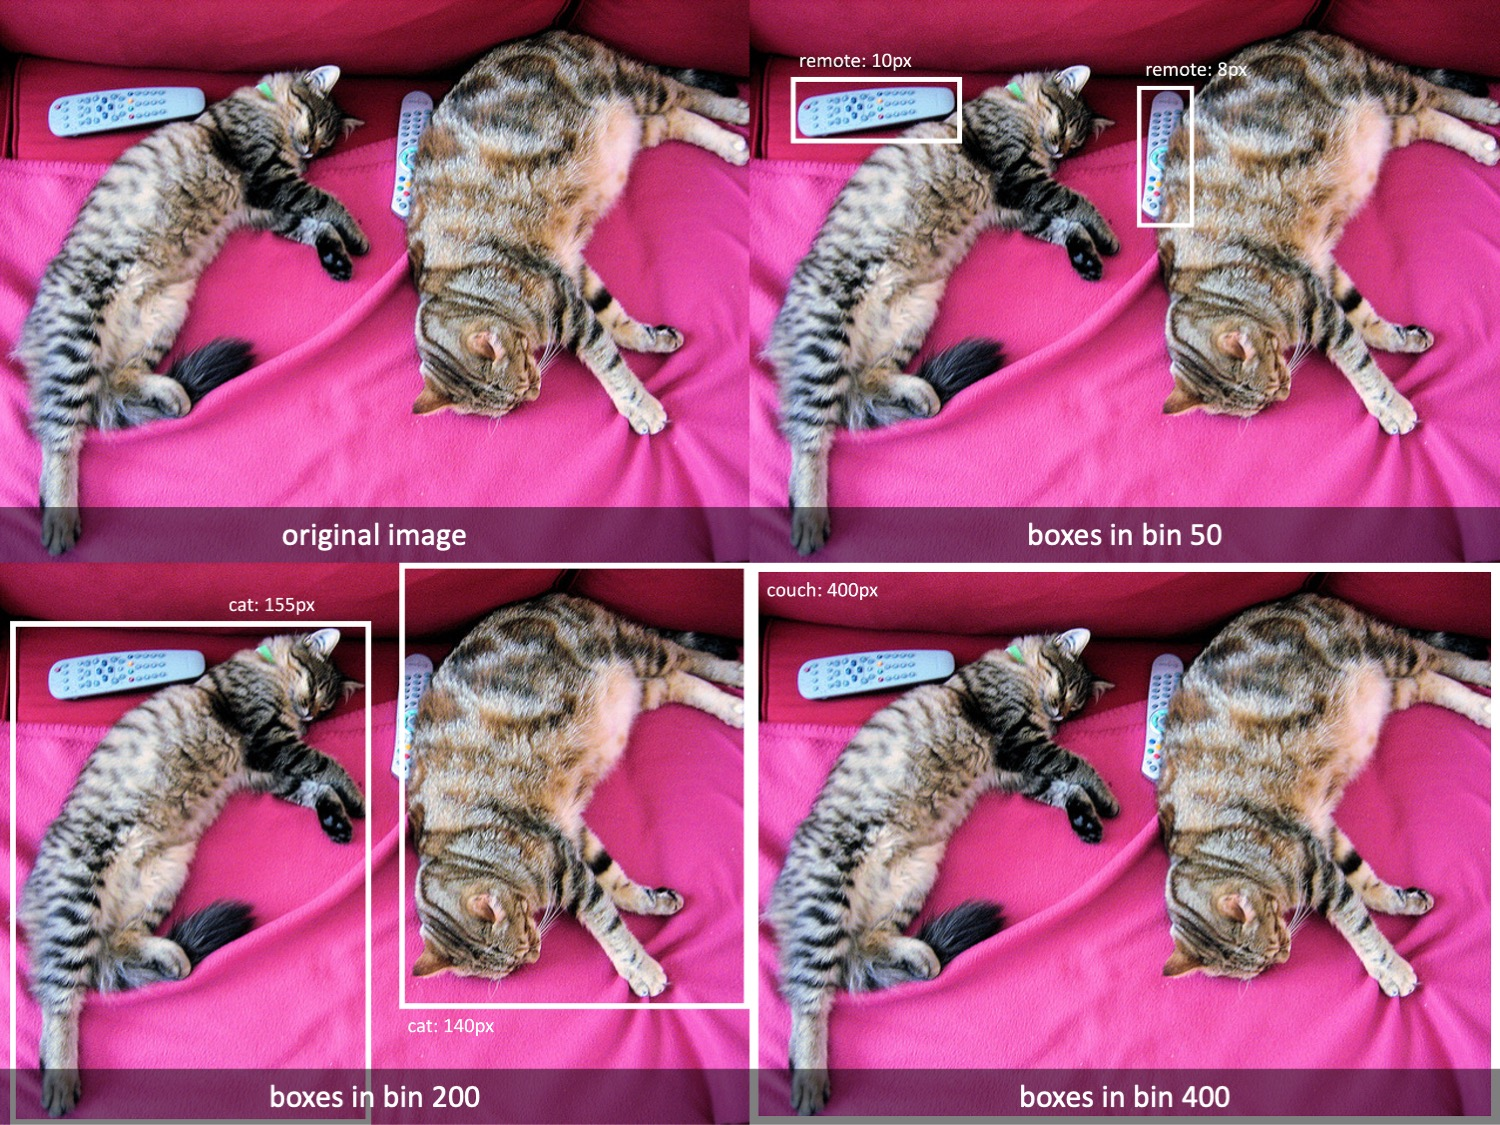
**Figure 3.** Example objects and their bounding boxes and bins

## 5) Results

### 5.1) Average Precision vs Resolution
The results of the first experiment are displayed in the figure below. Clearly, the average precision (AP) decreases for a lower resolution. This is what we would expect, because a lower resolution in object detection simply means less information to solve the same task. However, the course of the line shows that the AP degrades much more when resolutions become lower than 400 pixels as opposed to resolutions above 400 pixels. For applications that have limited compute power and that are more tolerant to slight errors, it might be beneficial to use 400 pixels or 500 pixels as resolution. In this case one will give in slightly on AP, while the input data is decreased by a lot.

Furthermore, this shows that DETR is highly sensitive to low resolutions which explains its low accuracy on small objects.

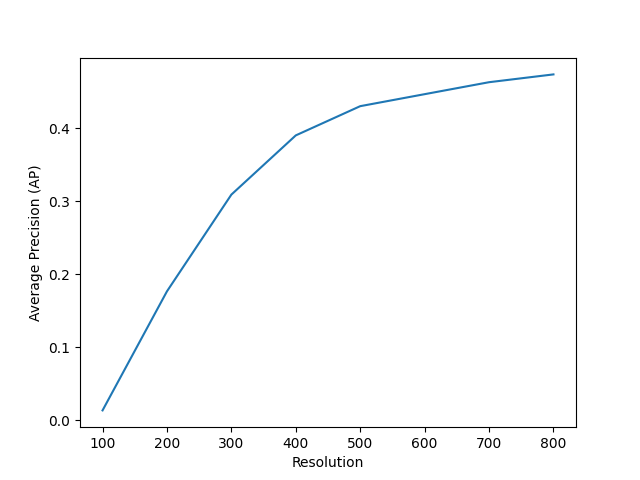

**Figure 4.** Average precision over resolution

In [ ]:
#@title Plot Average Precision vs Resolution
APs = []
for size in resolutions:
  APs.append(results_resolutions[str(size)][0])

fig = plt.plot(resolutions, APs)
plt.ylabel('Average Precision (AP)')
plt.xlabel('Resolution')

# Create directory
path = './results'
if not os.path.exists(path):
  os.mkdir(path)
plt.savefig(f"{path}/resolution_plot.png")

### 5.2) Average Precision vs Object Size per Resolution
Using the average precision vs object size per resolution calculations we can now plot the data. We first plot the data for objects up until 800 pixels, which are relatively small objects.

First notice that the object size is the size of the object in the unscaled image. When we look at different resolutions, this means that the actual object size in a rescaled image is smaller. Take for example an image of 800 pixels and and an object of 80 pixels. When we rescale the image to 80 pixels (10 times smaller) the objects size will also be 10 times smaller: 8 pixels.

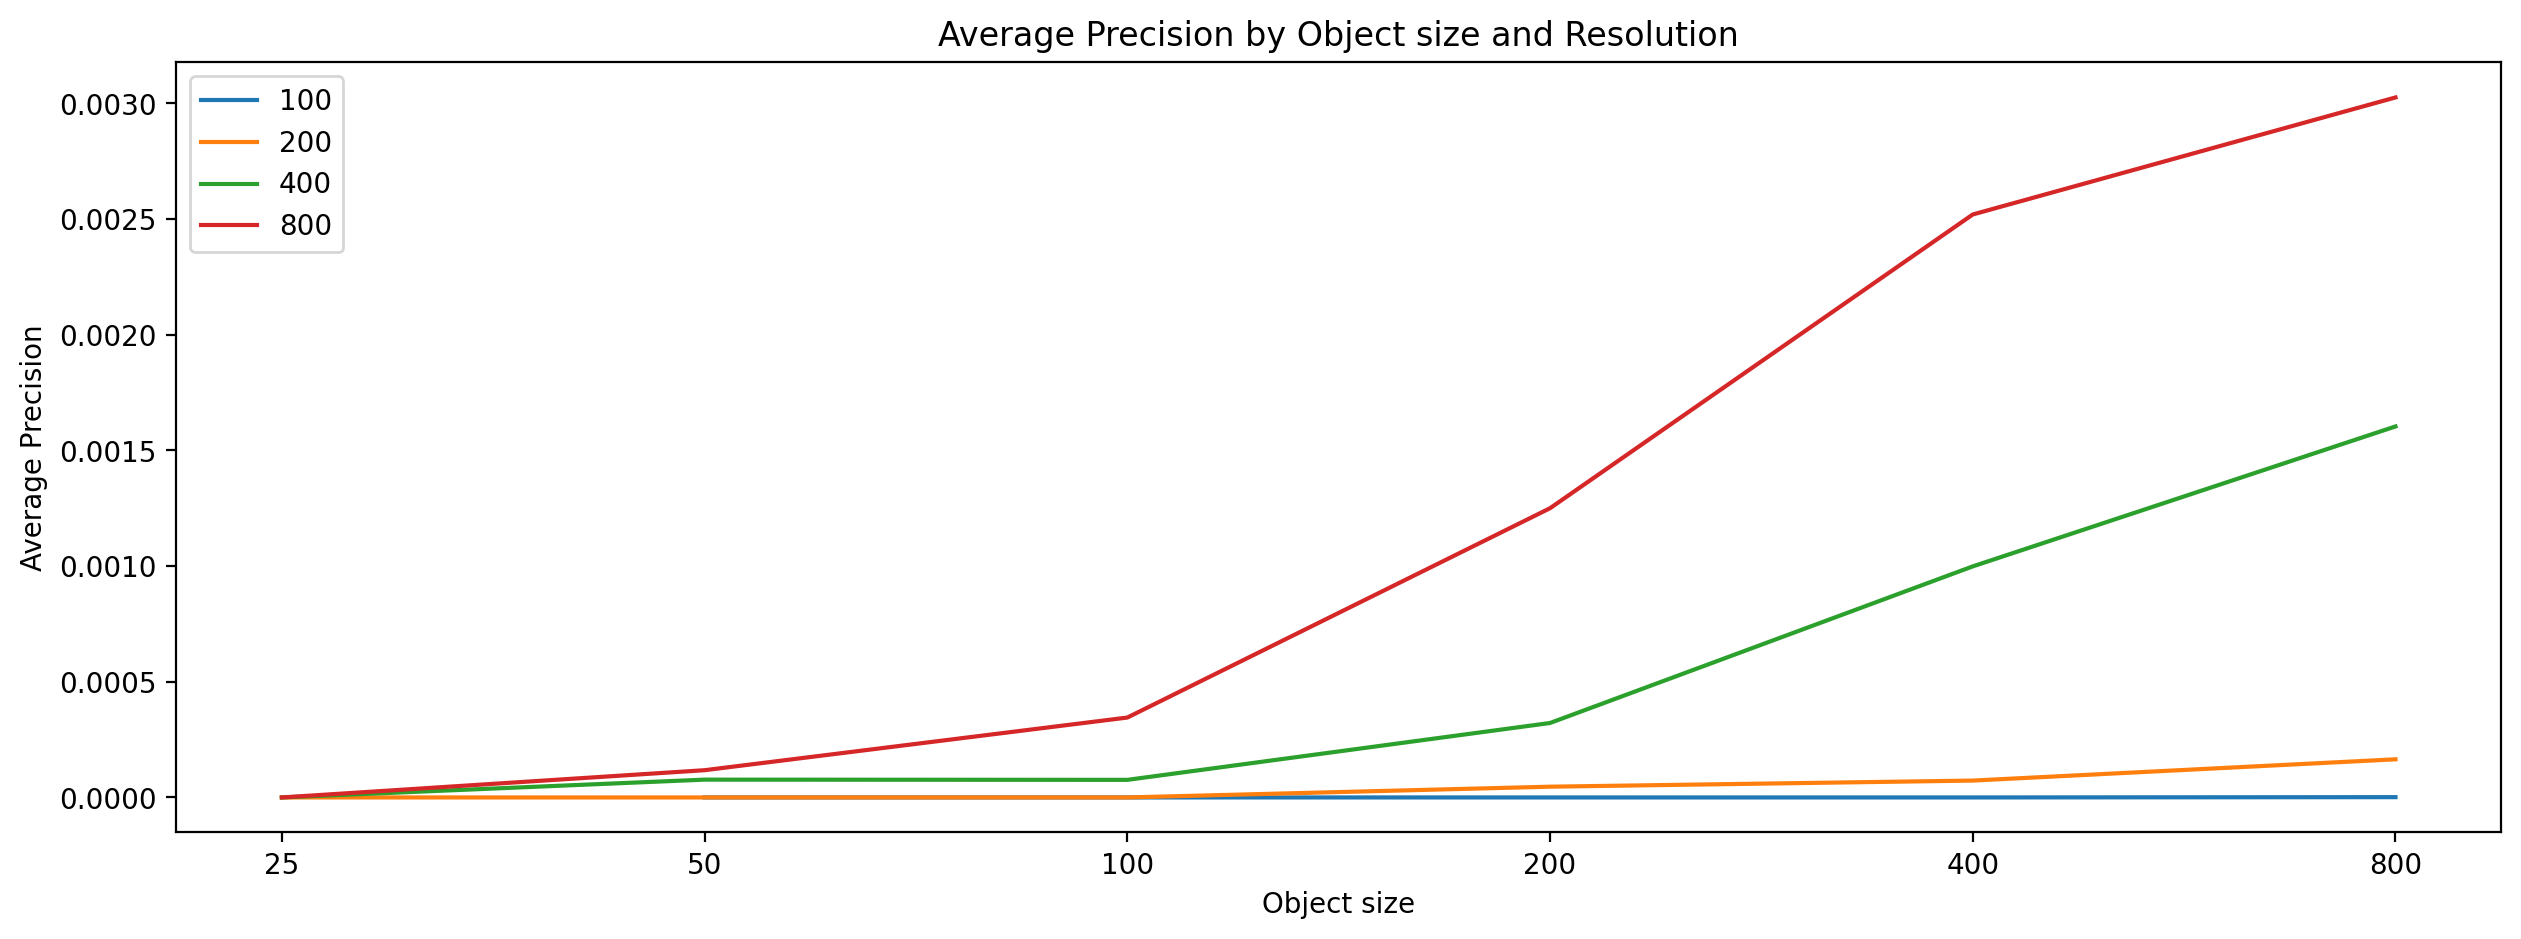

**Figure 5.** Average Precision by Object size and Resolution for small objects

In the introduction of the experiments section, we mentioned the expectation of the second experiment. Halving the resolutions whilst doubling the object size should give approximately the same result. In Figure 5 this would mean that each resolution line should have the same slope and translated to the right by two times the object size.

As we can see in Figure 6 this is not always the case. For objects sizes 100 and 200 with resolutions 400 and 800 it holds, but for larger object sizes and smaller resolutions it is slightly off.

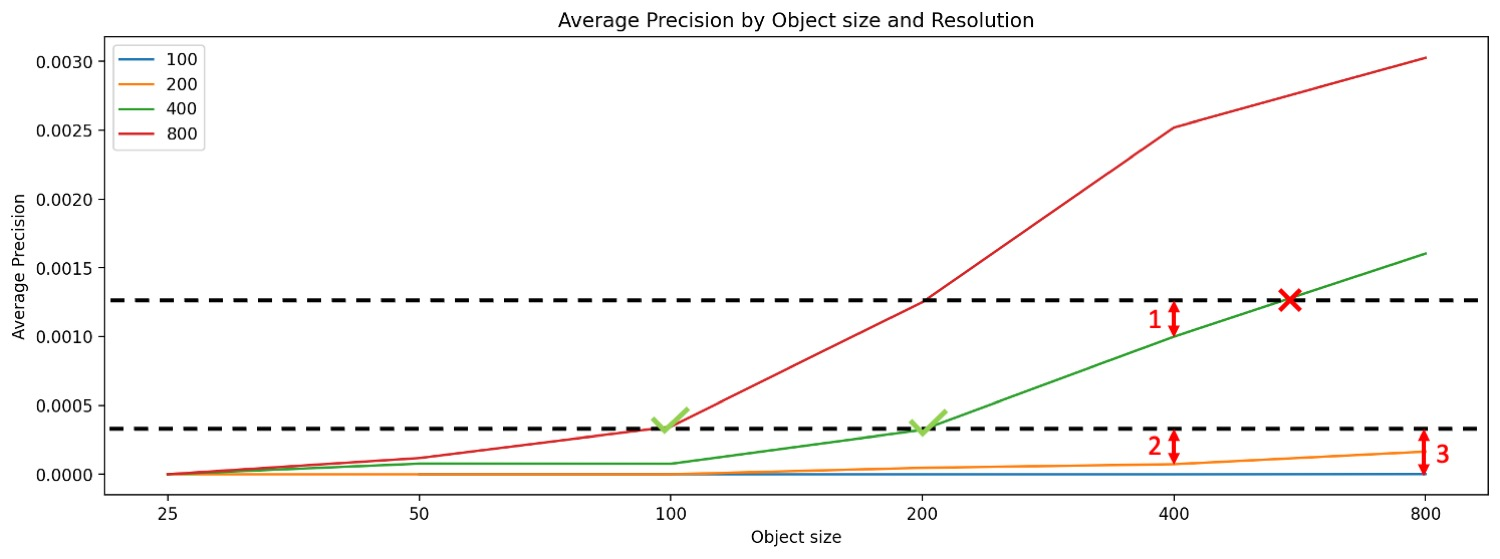

**Figure 6.** Slope of lines for different resolutions are not parallel like expected.

This trend can also be seen when we repeat the experiment for larger object sizes. Especially the 100 pixel image is hard to predict and does not follow the previously discussed principle of translation. We can also see that the different sizes of images have different peak levels of average precision where smaller resolutions are slightly shifted to the right, similarly like we expected for the smaller values.

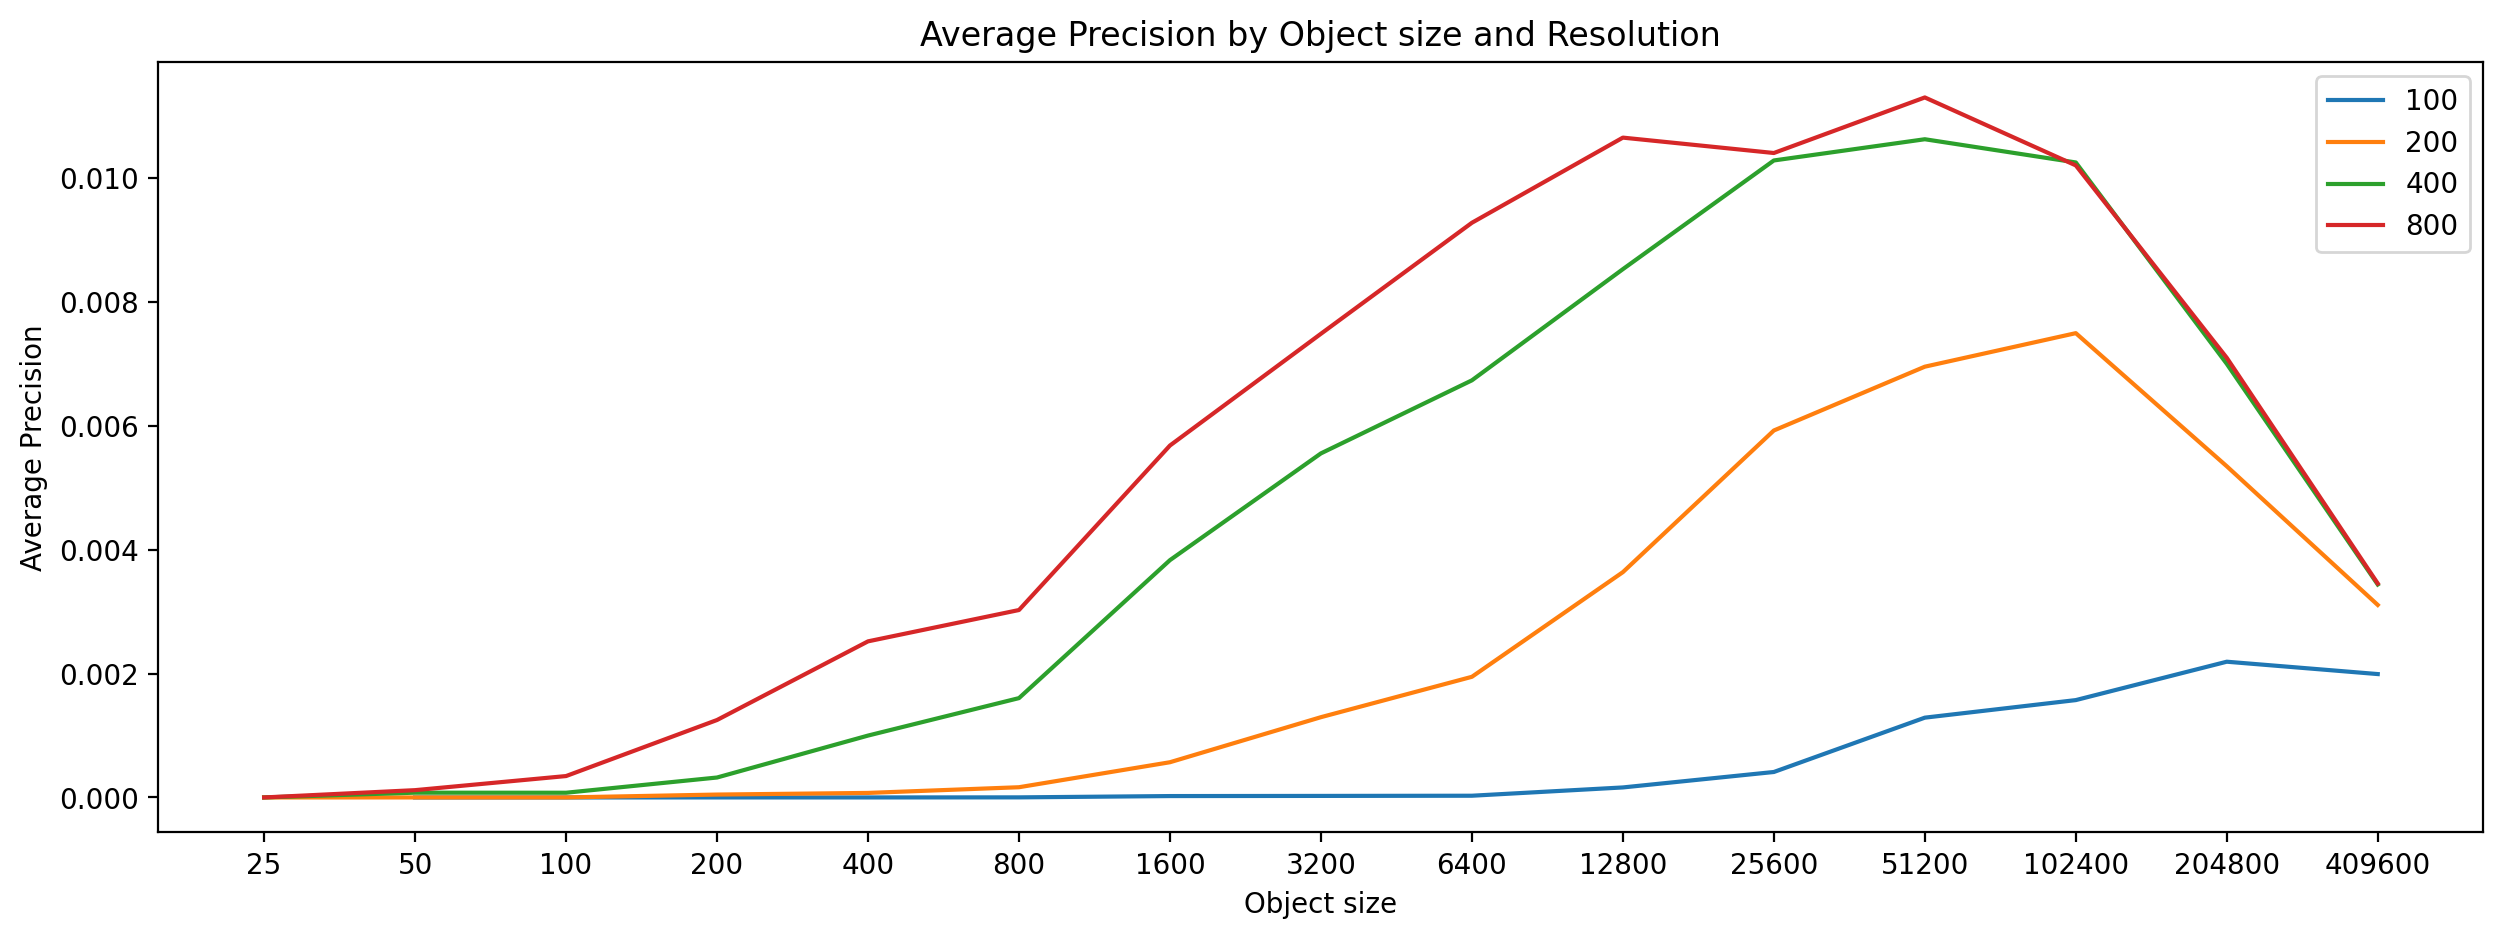

**Figure 7.** Average Precision by Object size and Resolution for all sizes

We can thus see that the correlation between resolution and object size does not scale to average precision as we expected, especially for smaller resolutions. This again shows that DETR is not robust to low resolutions.

In [ ]:
#@title Plot Average Precision vs Object Size per Resolution
def plot_object_size(log_scale, small, double):
  # Set figure size
  plt.figure(figsize=(15, 5))

  # Loop over resolutions
  for resolution, bins in results.items():
    # Check if we only want to print double resolutions
    if resolution in [300,500,600,700] and double:
      continue

    # Initialize lists to store x and y values for plotting
    x = []
    y = []

    # Loop over bins
    for bin_name, precision_values in bins.items():
        # Check if want to plot small resolutions, skip larger ones
        if bin_name > 800 and small:
          break

        # Append bin_num to x
        x.append(bin_name)

        # Append average precision values to y
        y.append(precision_values[0])

    # Plot the line
    plt.plot(x, y, label=resolution)

  # Add labels and title
  plt.xlabel("Object size")
  plt.xscale('log', base=2)
  plt.xticks(x, x)
  plt.ylabel("Average Precision")
  if log_scale:
    plt.yscale('log', base=2)
  plt.title("Average Precision by Object size and Resolution")
  plt.legend()
  plt.show()

# Call functions
plot_object_size(False, True, True)
plot_object_size(False, False, True)

### 5.3) Qualitative analysis

In this section we will show an example to compare how a small and a large object experience the resolution experiment and another example where a large object is suddenly recognized when the resolution decreases.

#### 5.3.1) Small and large object comparison

First of all, we will compare a small and a large object in the same image. Below the image under investigation is displayed with its ground truth annotations.

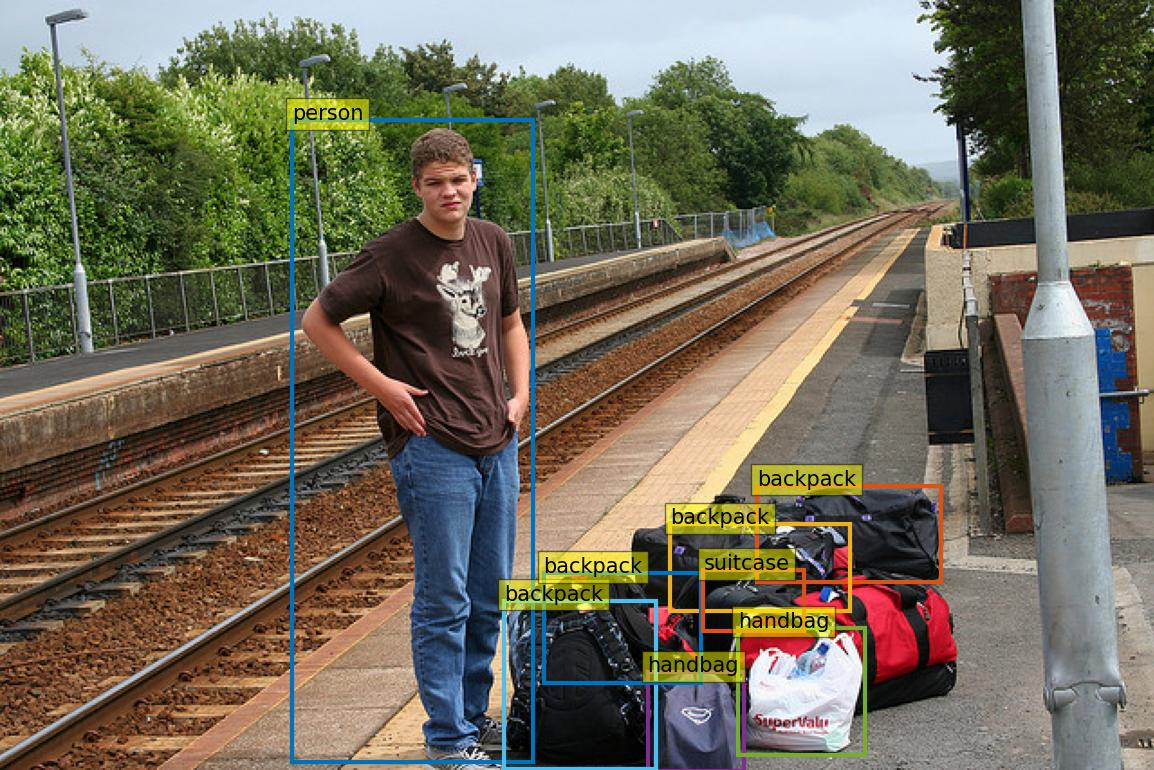

**Figure 8.** Image with ground thuth bounding boxes

We will pick the person as the large object and one of the backpacks as the small object. The image has been exposed to the experiment as a whole, but for the sake of comparison we isolate the person and the backpack from the results. In Figure 9 these isolated results are shown at scale. The resolutions from left to right are 800, 400, 200, and 100.

Both objects are assigned the correct label for every resolution. The bounding boxes are also close to the ground truth, except for a resolution of 100. In this particular example, decreasing the resolution has the same effect on the large object as the small object. This indicates that initially being represented by less pixels, does not necessarily mean that DETR will perform worse. As this is a single example, we cannot draw any further conclusions from it.

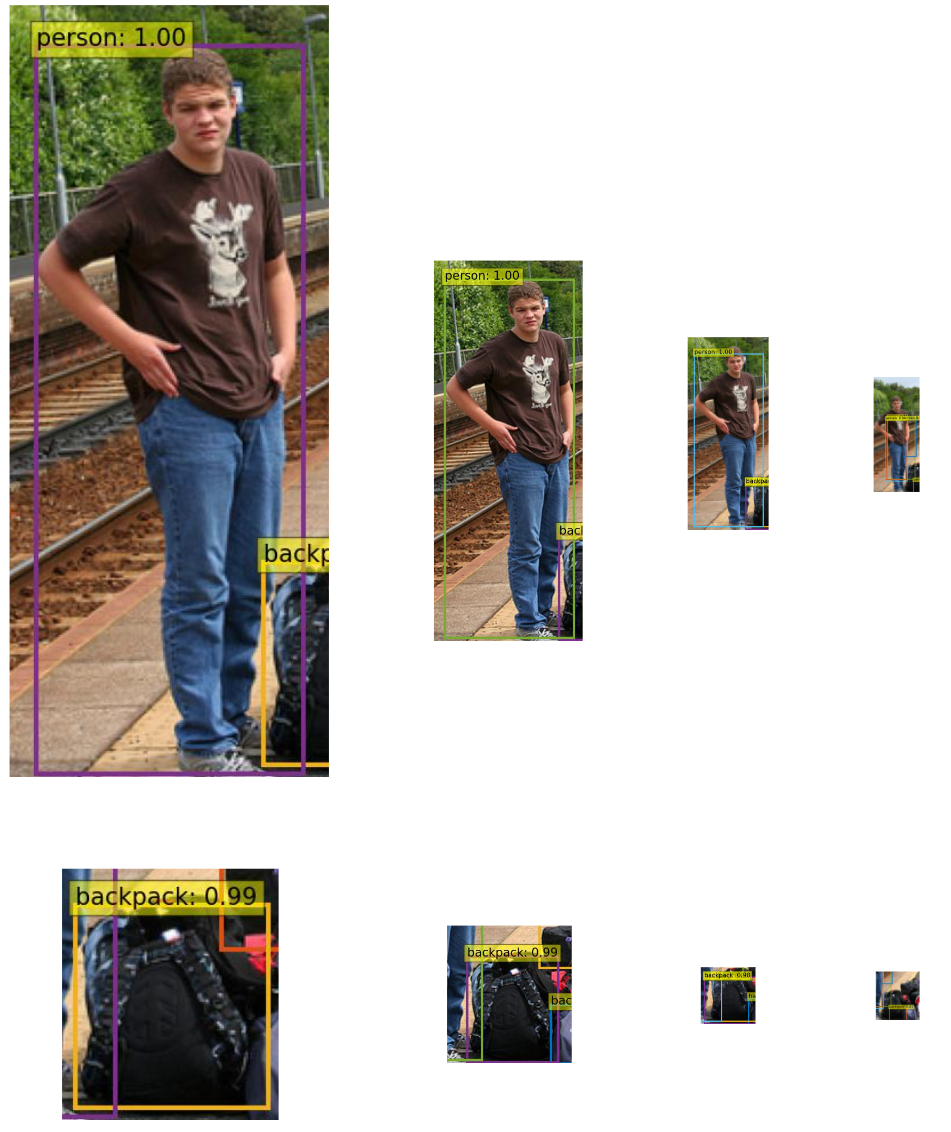

**Figure 9.** Scaling down resolutions with predicted bounding boxes

#### 5.3.2) Large object recognized with decreased resolution

The plots in section 5.2 showed the AP for the largest objects is lower than for slighlty smaller objects. This might mean that decreasing the resolution, and thereby the size of the object, could lead to a higher AP. Below an example is shown where this is the case.

Note that DETR does not detect the bowl in the original image (resolution of 800), whereas it is recognized in lower resolutions. Again, this is not a proof that decreasing resolution increases the AP for larger objects. It is only an example that serves as a possible explanation of the 'bump' visible in the plots in section 5.2.



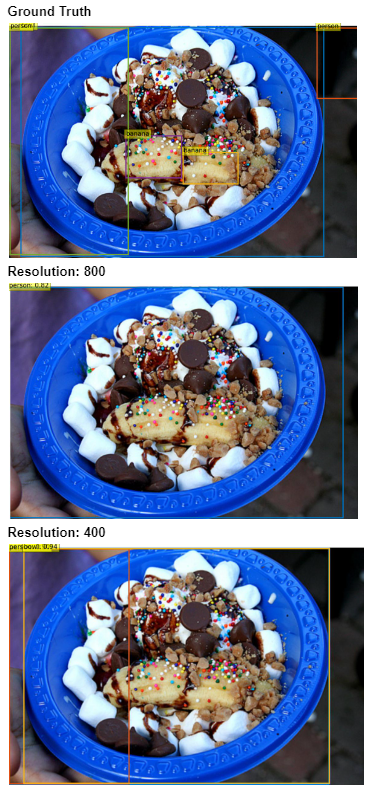

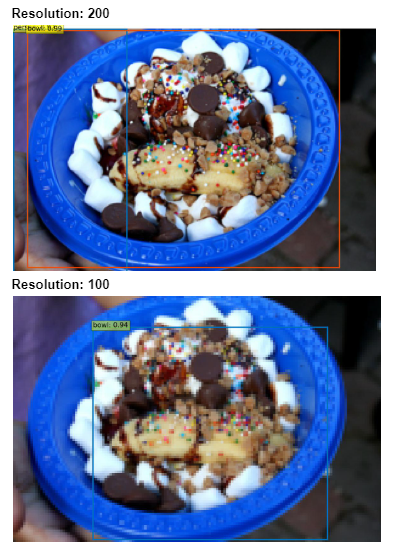

**Figure 10.** Instance with ground truth and different resolutions, we can see that higher resolutions do not always result in more accuracte predictions

## 6) Conclusion

This blog aimed to build an understanding of when and why DETR yields low performance on small objects. For this purpose, we studied how the average precision of DETR changes per object size for lower resolution images. We found that DETR is highly sensitive to lower resolutions, which can explain its struggles with small objects which are inherently presented by less pixels. On the other hand, we did not find any irregularities between different object sizes and the decreasing resolution. A suggestion to improve DETR on smaller objects would therefore be to train it more on lower resolution images.

This work specifically focused on decreasing resolutions. We know that DETR performs well due to its both global and local scope when estimating bounding boxes. For future research it might be beneficial to look into the relative object size within an image (object_size / image_size) as this might further tell us something about the behaviour of small objects in large images. Similarly it would be benificial to investigate the size of an object relative to the largest object in the image (object_size / largest_object_size).

# References
1. Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, L., & Polosukhin, I. (2017). Attention Is All You Need. arXiv preprint arXiv:1706.03762.

2. Carion, N., Massa, F., Synnaeve, G., Usunier, N., Kirillov, A., & Zagoruyko, S. (2020). End-to-End Object Detection with Transformers. arXiv preprint arXiv:2005.12872.

3. Redmon, J., Divvala, S., Girshick, R., & Farhadi, A. (2016). You Only Look Once: Unified, Real-Time Object Detection. arXiv preprint arXiv:1506.02640.

4. Ren, S., He, K., Girshick, R., & Sun, J. (2016). Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks. arXiv preprint arXiv:1506.01497.

5. He, L., & Todorovic, S. (2022). DESTR: Object Detection with Split Transformer. 2022 IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR), 9367-9376.

6. Dubey, S., Olimov, F., Rafique, M. A., & Jeon, M. (2022). Improving small objects detection using transformer. Journal of Visual Communication and Image Representation, 89, 103620. https://doi.org/10.1016/j.jvcir.2022.103620

7. Stewart, R.J., Andriluka, M., Ng, A.Y. (2015). End-to-end people detection in crowded scenes. In: CVPR

8. Hosang, J.H., Benenson, R., Schiele, B. (2017). Learning non-maximum suppression. In: CVPR

9.  Bodla, N., Singh, B., Chellappa, R., Davis, L.S. (2017). Soft-NMS improving object detection with one line of code. In: ICCV

10.  Rezatofighi, S.H., Kaskman, R., Motlagh, F.T., Shi, Q., Cremers, D., Leal-Taix´e, L., Reid, I. (2018). Deep perm-set net: Learn to predict sets with unknown permutation and cardinality using deep neural networks. arXiv:1805.00613
